**Detecção de Fraude – Modelagem com Random Forest**

Este notebook apresenta a construção e avaliação de um modelo de Random Forest para detecção de fraudes em seguros. Inclui análise detalhada das métricas de desempenho, ajuste de threshold para otimização da detecção de fraudes e interpretação das variáveis mais importantes. 

**Objetivo:**

O objetivo é identificar a capacidade do modelo em capturar a classe minoritária em um cenário desbalanceado, priorizando a redução de falsos negativos.

**Dataset**

Este conjunto de dados contém informações sobre veículos: atributos, modelo, detalhes de acidentes, etc. Juntamente com detalhes da apólice: tipo de apólice, duração, etc. O objetivo é detectar se uma solicitação de indenização é fraudulenta ou não, variável: FraudFound_P

Dataset: https://www.kaggle.com/datasets/shivamb/vehicle-claim-fraud-detection/data

In [2]:
#Importação dos pacotes necessários

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import StandardScaler

In [3]:
# Função Auxiliar
# Verifica se o modelo de regressão é estatisticamente significativo.
def checar_significancia_modelo(modelo, alpha=0.05):
    """
    Parâmetros:
        modelo : objeto de regressão do statsmodels (ex.: OLS.fit())
        alpha  : nível de significância (default = 0.05)

    Retorna:
        str : mensagem indicando se o modelo é significativo.
    """

    p_valor = modelo.f_pvalue  # p-value do teste F

    if p_valor < alpha:
        return f"O modelo é estatisticamente significativo (p-value = {p_valor:.4e})."
    else:
        return f"O modelo NÃO é estatisticamente significativo (p-value = {p_valor:.4e})."

In [4]:
# Função Tabela de quantidade (%) para todas as colunas

def resumo_todas_colunas(df):
    resultados = {}

    for col in df.columns:
        # Descrição da coluna
        counts = df[col].value_counts(dropna=False)
        percent = df[col].value_counts(normalize=True, dropna=False) * 100
        
        tabela = pd.DataFrame({
            'quantidade': counts,
            'percentual (%)': percent.round(2)
        })
        
        resultados[col] = tabela
    
    return resultados

In [5]:
#Exportar todas as tabelas (uma por coluna) para Excel

def exportar_resumo_para_excel(resumo_dict, arquivo="resumo.xlsx"):
    with pd.ExcelWriter(arquivo, engine="xlsxwriter") as writer:
        for col, tabela in resumo_dict.items():
            # Nome da aba não pode ter mais que 31 caracteres
            nome_aba = col[:31]
            tabela.to_excel(writer, sheet_name=nome_aba)
    print(f"Arquivo '{arquivo}' criado com sucesso!")

In [6]:
#Converte automaticamente todas as colunas categóricas em dummies.

def transformar_categoricas_em_dummies(df, drop_first=False):
    """
    Converte automaticamente todas as colunas categóricas em dummies.

    - df: DataFrame original
    - drop_first: remove a primeira dummy para evitar multicolinearidade (opcional)

    Retorna:
        novo_df: DataFrame com variáveis dummy
    """
    
    # Identifica colunas categóricas automaticamente
    cols_categoricas = df.select_dtypes(include=['object', 'category']).columns
    
    # Aplica o get_dummies
    df_dummies = pd.get_dummies(df, columns=cols_categoricas, drop_first=drop_first)
    
    return df_dummies


In [7]:
# Rotina para remover automaticamente variáveis com alta colinearidade.

def remover_multicolinearidade(df, limite_corr=0.95):
    """
    Remove automaticamente colunas com colinearidade alta.
    
    Passos:
    1. Remove colunas constantes
    2. Remove colunas com baixa variância (quase constantes)
    3. Remove colunas altamente correlacionadas entre si (> limite_corr)
    
    Retorna:
        df_limpo: DataFrame sem multicolinearidade
        colunas_removidas: lista das colunas eliminadas
    """
    
    df_limpo = df.copy()
    colunas_removidas = []

    # ----------------------------------------------------------------------
    # 1. Remover colunas constantes
    # ----------------------------------------------------------------------
    constantes = [col for col in df_limpo.columns if df_limpo[col].nunique() <= 1]
    
    df_limpo.drop(columns=constantes, inplace=True)
    colunas_removidas.extend(constantes)
    
    
    # ----------------------------------------------------------------------
    # 2. Remover colunas quase constantes (≥ 99% do mesmo valor)
    # ----------------------------------------------------------------------
    quase_constantes = []
    for col in df_limpo.columns:
        freq = df_limpo[col].value_counts(normalize=True, dropna=False)
        if freq.iloc[0] >= 0.99:   # Ajustável
            quase_constantes.append(col)
    
    df_limpo.drop(columns=quase_constantes, inplace=True)
    colunas_removidas.extend(quase_constantes)
    
    
    # ----------------------------------------------------------------------
    # 3. Remover colunas altamente correlacionadas
    # ----------------------------------------------------------------------
    corr = df_limpo.corr().abs()

    upper_tri = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    
    colinearidade_alta = [
        col for col in upper_tri.columns 
        if any(upper_tri[col] > limite_corr)
    ]

    df_limpo.drop(columns=colinearidade_alta, inplace=True)
    colunas_removidas.extend(colinearidade_alta)

    
    # ----------------------------------------------------------------------
    print("🔍 Remoção de multicolinearidade concluída.")
    print(f"➡ Colunas removidas ({len(colunas_removidas)}):")
    for col in colunas_removidas:
        print(" -", col)

    return df_limpo, colunas_removidas

In [8]:
# Função para a definição da matriz de confusão

from sklearn.metrics import confusion_matrix, accuracy_score,\
    ConfusionMatrixDisplay, recall_score

def matriz_confusao(predicts, observado, cutoff):
    
    values = predicts.values
    
    predicao_binaria = []
        
    for item in values:
        if item < cutoff:
            predicao_binaria.append(0)
        else:
            predicao_binaria.append(1)
           
    cm = confusion_matrix(predicao_binaria, observado)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.xlabel('True')
    plt.ylabel('Classified')
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.show()
        
    sensitividade = recall_score(observado, predicao_binaria, pos_label=1)
    especificidade = recall_score(observado, predicao_binaria, pos_label=0)
    acuracia = accuracy_score(observado, predicao_binaria)

    #Visualizando os principais indicadores desta matriz de confusão
    indicadores = pd.DataFrame({'Sensitividade':[sensitividade],
                                'Especificidade':[especificidade],
                                'Acurácia':[acuracia]})
    return indicadores

In [9]:
# Importar o banco de dados
    
df = pd.read_csv('fraud_oracle.csv', delimiter=',')

In [10]:
# Visualizando essa base
df.head(3)

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision


In [11]:
# Retornando o shape da base
df.shape

(15420, 33)

In [12]:
#Características das variáveis do dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

In [13]:
#Estatísticas univariadas
df.describe()

,WeekOfMonth,WeekOfMonthClaimed,Age,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Year
count,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000
mean,2.788586,2.693969,39.855707,0.059857,7710.500000,8.483268,407.704280,2.487808,1994.866472
std,1.287585,1.259115,13.492377,0.237230,4451.514911,4.599948,43.950998,1.119453,0.803313
min,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,300.000000,1.000000,1994.000000
25%,2.000000,2.000000,31.000000,0.000000,3855.750000,5.000000,400.000000,1.000000,1994.000000
50%,3.000000,3.000000,38.000000,0.000000,7710.500000,8.000000,400.000000,2.000000,1995.000000
75%,4.000000,4.000000,48.000000,0.000000,11565.250000,12.000000,400.000000,3.000000,1996.000000
max,5.000000,5.000000,80.000000,1.000000,15420.000000,16.000000,700.000000,4.000000,1996.000000


In [14]:
# Análise das 5 ultimas linhas do dataset
df.tail()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
15415,Nov,4,Friday,Toyota,Urban,Tuesday,Nov,5,Male,Married,...,6 years,31 to 35,No,No,External,none,no change,1 vehicle,1996,Collision
15416,Nov,5,Thursday,Pontiac,Urban,Friday,Dec,1,Male,Married,...,6 years,31 to 35,No,No,External,more than 5,no change,3 to 4,1996,Liability
15417,Nov,5,Thursday,Toyota,Rural,Friday,Dec,1,Male,Single,...,5 years,26 to 30,No,No,External,1 to 2,no change,1 vehicle,1996,Collision
15418,Dec,1,Monday,Toyota,Urban,Thursday,Dec,2,Female,Married,...,2 years,31 to 35,No,No,External,more than 5,no change,1 vehicle,1996,All Perils
15419,Dec,2,Wednesday,Toyota,Urban,Thursday,Dec,3,Male,Single,...,5 years,26 to 30,No,No,External,1 to 2,no change,1 vehicle,1996,Collision


In [15]:
# Formato das variaveis
df.dtypes

Month                   object
WeekOfMonth              int64
DayOfWeek               object
Make                    object
AccidentArea            object
DayOfWeekClaimed        object
MonthClaimed            object
WeekOfMonthClaimed       int64
Sex                     object
MaritalStatus           object
Age                      int64
Fault                   object
PolicyType              object
VehicleCategory         object
VehiclePrice            object
FraudFound_P             int64
PolicyNumber             int64
RepNumber                int64
Deductible               int64
DriverRating             int64
Days_Policy_Accident    object
Days_Policy_Claim       object
PastNumberOfClaims      object
AgeOfVehicle            object
AgeOfPolicyHolder       object
PoliceReportFiled       object
WitnessPresent          object
AgentType               object
NumberOfSuppliments     object
AddressChange_Claim     object
NumberOfCars            object
Year                     int64
BasePoli

In [16]:
# Visualizando quantidade de valores vazios
(df.isnull().sum()/df.shape[0]).sort_values(ascending=False).head(20)

Month                   0.0
RepNumber               0.0
Year                    0.0
NumberOfCars            0.0
AddressChange_Claim     0.0
NumberOfSuppliments     0.0
AgentType               0.0
WitnessPresent          0.0
PoliceReportFiled       0.0
AgeOfPolicyHolder       0.0
AgeOfVehicle            0.0
PastNumberOfClaims      0.0
Days_Policy_Claim       0.0
Days_Policy_Accident    0.0
DriverRating            0.0
Deductible              0.0
PolicyNumber            0.0
WeekOfMonth             0.0
FraudFound_P            0.0
VehiclePrice            0.0
dtype: float64

In [17]:
# Tabela de frequências absolutas da variável 'FraudFound_P'

#df['FraudFound_P'].value_counts(dropna=False) * 100
df['FraudFound_P'].value_counts(normalize=True, dropna=False) * 100

FraudFound_P
0    94.014267
1     5.985733
Name: proportion, dtype: float64

In [20]:
# Executa análise
resumo = resumo_todas_colunas(df)

# Exporta
exportar_resumo_para_excel(resumo, "resumo_todas_colunas.xlsx")

Arquivo 'resumo_todas_colunas.xlsx' criado com sucesso!


In [18]:
##DayOfWeekClaimed: Removendo valor 0, onde Identiquei somente 1 caso
df = df[df['DayOfWeekClaimed'] != '0']

#Days_Policy_Accident: Identificado 0,36% de registros = "None"
#Optei por manter os registros, pois em modelos de detecção de fraude costumam considerar missing como uma categoria válida, porque o padrão de ausência pode revelar comportamento fraudulento.


In [19]:
# Criar dummies
# Transformando as variáveis categóricas em dummies
df_dummies = pd.get_dummies(df, drop_first=True)

# Remove colinearidade
df_sem_colinearidade, removidas = remover_multicolinearidade(df_dummies, limite_corr=0.95)

print("Formato original:", df.shape)
print("Dimensão antes:", df_dummies.shape)
print("Dimensão depois:", df_sem_colinearidade.shape)


🔍 Remoção de multicolinearidade concluída.
➡ Colunas removidas (33):
 - Make_BMW
 - Make_Dodge
 - Make_Ferrari
 - Make_Jaguar
 - Make_Lexus
 - Make_Mecedes
 - Make_Mercury
 - Make_Nisson
 - Make_Porche
 - Make_Saab
 - Make_Saturn
 - DayOfWeekClaimed_Saturday
 - DayOfWeekClaimed_Sunday
 - MaritalStatus_Widow
 - PolicyType_Sport - All Perils
 - PolicyType_Sport - Liability
 - PolicyType_Utility - Collision
 - PolicyType_Utility - Liability
 - VehiclePrice_60000 to 69000
 - Days_Policy_Accident_15 to 30
 - Days_Policy_Accident_8 to 15
 - Days_Policy_Accident_none
 - Days_Policy_Claim_8 to 15
 - Days_Policy_Claim_more than 30
 - AgeOfVehicle_3 years
 - AgeOfPolicyHolder_18 to 20
 - AgeOfPolicyHolder_21 to 25
 - WitnessPresent_Yes
 - AddressChange_Claim_under 6 months
 - NumberOfCars_5 to 8
 - NumberOfCars_more than 8
 - MaritalStatus_Single
 - BasePolicy_Liability
Formato original: (15419, 33)
Dimensão antes: (15419, 122)
Dimensão depois: (15419, 89)


In [20]:
# Formato das variaveis transformadas em dummies
df_sem_colinearidade.dtypes

WeekOfMonth                         int64
WeekOfMonthClaimed                  int64
Age                                 int64
FraudFound_P                        int64
PolicyNumber                        int64
                                    ...  
AddressChange_Claim_4 to 8 years     bool
AddressChange_Claim_no change        bool
NumberOfCars_2 vehicles              bool
NumberOfCars_3 to 4                  bool
BasePolicy_Collision                 bool
Length: 89, dtype: object

In [22]:
# converte as colunas bool para int.
df_dummies = df_sem_colinearidade.astype({col: 'int' for col in df_sem_colinearidade.select_dtypes('bool').columns})

#df2['smoker_yes'] = df2['smoker_yes'].astype(int)
#df2['region_northwest'] = df2['region_northwest'].astype(int)
#df2['region_southeast'] = df2['region_southeast'].astype(int)
#df2['region_southwest'] = df2['region_southwest'].astype(int)


In [23]:
# Formato das variaveis transformadas em dummies
df_dummies.dtypes

WeekOfMonth                         int64
WeekOfMonthClaimed                  int64
Age                                 int64
FraudFound_P                        int64
PolicyNumber                        int64
                                    ...  
AddressChange_Claim_4 to 8 years    int64
AddressChange_Claim_no change       int64
NumberOfCars_2 vehicles             int64
NumberOfCars_3 to 4                 int64
BasePolicy_Collision                int64
Length: 89, dtype: object

In [24]:
# Ajustando o nome das colunas para melhor ajuste do modelo
df_dummies.columns = (
    df_dummies.columns
    .str.replace(" ", "_", regex=False)
    .str.replace("-", "_", regex=False)
    .str.replace("/", "_", regex=False)
    .str.replace(".", "_", regex=False)
)

In [25]:
# Validando o nome das variaveis apos ajuste das colunas
df_dummies.dtypes

WeekOfMonth                         int64
WeekOfMonthClaimed                  int64
Age                                 int64
FraudFound_P                        int64
PolicyNumber                        int64
                                    ...  
AddressChange_Claim_4_to_8_years    int64
AddressChange_Claim_no_change       int64
NumberOfCars_2_vehicles             int64
NumberOfCars_3_to_4                 int64
BasePolicy_Collision                int64
Length: 89, dtype: object

In [26]:
# Estimação do modelo

lista_colunas = list(df_dummies.drop(columns=['FraudFound_P']).columns)

formula_dummies_modelo = ' + '.join(lista_colunas)

formula_dummies_modelo = "FraudFound_P ~ " + formula_dummies_modelo

print("Fórmula utilizada: ",formula_dummies_modelo)

Fórmula utilizada:  FraudFound_P ~ WeekOfMonth + WeekOfMonthClaimed + Age + PolicyNumber + RepNumber + Deductible + DriverRating + Year + Month_Aug + Month_Dec + Month_Feb + Month_Jan + Month_Jul + Month_Jun + Month_Mar + Month_May + Month_Nov + Month_Oct + Month_Sep + DayOfWeek_Monday + DayOfWeek_Saturday + DayOfWeek_Sunday + DayOfWeek_Thursday + DayOfWeek_Tuesday + DayOfWeek_Wednesday + Make_Chevrolet + Make_Ford + Make_Honda + Make_Mazda + Make_Pontiac + Make_Toyota + Make_VW + AccidentArea_Urban + DayOfWeekClaimed_Monday + DayOfWeekClaimed_Thursday + DayOfWeekClaimed_Tuesday + DayOfWeekClaimed_Wednesday + MonthClaimed_Aug + MonthClaimed_Dec + MonthClaimed_Feb + MonthClaimed_Jan + MonthClaimed_Jul + MonthClaimed_Jun + MonthClaimed_Mar + MonthClaimed_May + MonthClaimed_Nov + MonthClaimed_Oct + MonthClaimed_Sep + Sex_Male + MaritalStatus_Married + Fault_Third_Party + PolicyType_Sedan___Collision + PolicyType_Sedan___Liability + PolicyType_Sport___Collision + PolicyType_Utility___All_P

### Separação entre variáveis explicativas (X) e alvo (y)

In [29]:
# Separação de X e Y

X = df_dummies.drop("FraudFound_P", axis=1)
y = df_dummies["FraudFound_P"]

### Divisão entre treino e teste

In [30]:
# Split

#Divide os dados em treino e teste, garantindo que a proporção das classes
#seja mantida (stratify).

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y
)

### Otimização de Hiperparâmetros com Grid Search

In [33]:
from sklearn.model_selection import GridSearchCV


param_grid = {
'n_estimators': [200, 300, 500],
'max_depth': [None, 10, 20],
'min_samples_split': [2, 5],
'min_samples_leaf': [1, 2]
}


grid = GridSearchCV(
estimator=rf,
param_grid=param_grid,
cv=3,
scoring='roc_auc',
n_jobs=-1
)


grid.fit(X_train, y_train)


print("Melhores parâmetros:", grid.best_params_)
print("Melhor AUC:", grid.best_score_)

Melhores parâmetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Melhor AUC: 0.8493624093328723


**Conclusão:**

A aplicação do **Random Forest**, seguida pelo ajuste fino via **Grid Search**, resultou em um modelo mais robusto e com melhor capacidade discriminativa. O processo de validação cruzada identificou como melhores hiperparâmetros: max_depth=None, min_samples_leaf=1, min_samples_split=2 e n_estimators=500.

Essa configuração apresentou desempenho superior, alcançando **AUC de 0.849**, indicando uma boa habilidade do modelo em separar corretamente casos de fraude e não fraude.

### Predições

In [34]:
# Predições
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]

### Avaliação das Métricas

In [36]:
# Métricas
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      4349
           1       0.50      0.01      0.01       277

    accuracy                           0.94      4626
   macro avg       0.72      0.50      0.49      4626
weighted avg       0.91      0.94      0.91      4626



**Conclusão:**
O modelo apresentou alta performance para a classe majoritária, com precisão de 0.94 e recall de 1.00, resultando em acurácia geral de 0.94.

Entretanto, o desempenho para a classe de fraude foi significativamente inferior, com recall de apenas 0.01, indicando dificuldade em identificar ocorrências positivas.

As médias macro e ponderada refletem essa discrepância, evidenciando forte desbalanceamento na capacidade preditiva entre as classes

### AUC ROC – Avaliação do Modelo

In [42]:
roc_auc = roc_auc_score(y_test, y_prob)
roc_auc

0.8704893361102971

**Conclusão:**
O modelo apresentou um AUC-ROC de 0.87, indicando boa capacidade discriminativa para diferenciar casos de fraude e não fraude.

Esse resultado demonstra que, apesar das limitações nas métricas por classe, o modelo captura bem o padrão geral de separação entre as categorias.

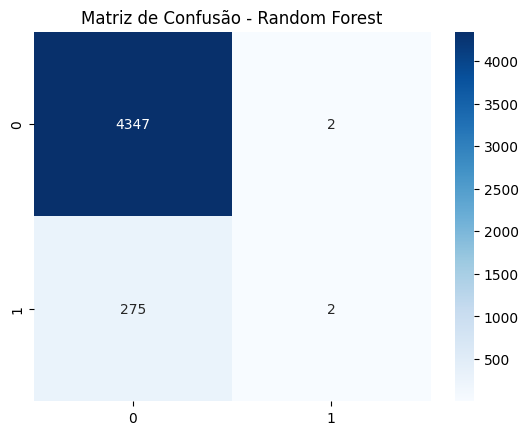

In [38]:
# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão - Random Forest')
plt.show()

### Visualização da Curva ROC

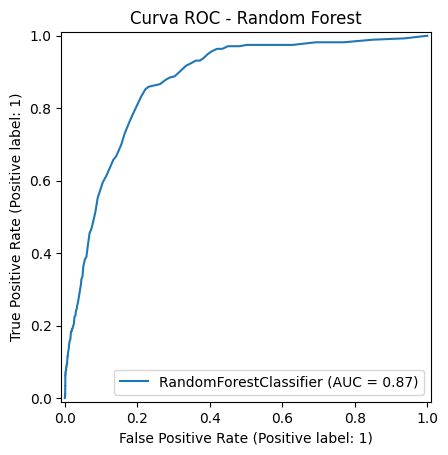

In [39]:
# Curva ROC
RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.title('Curva ROC - Random Forest')
plt.show()

### Importância das Variáveis (Feature Importance)

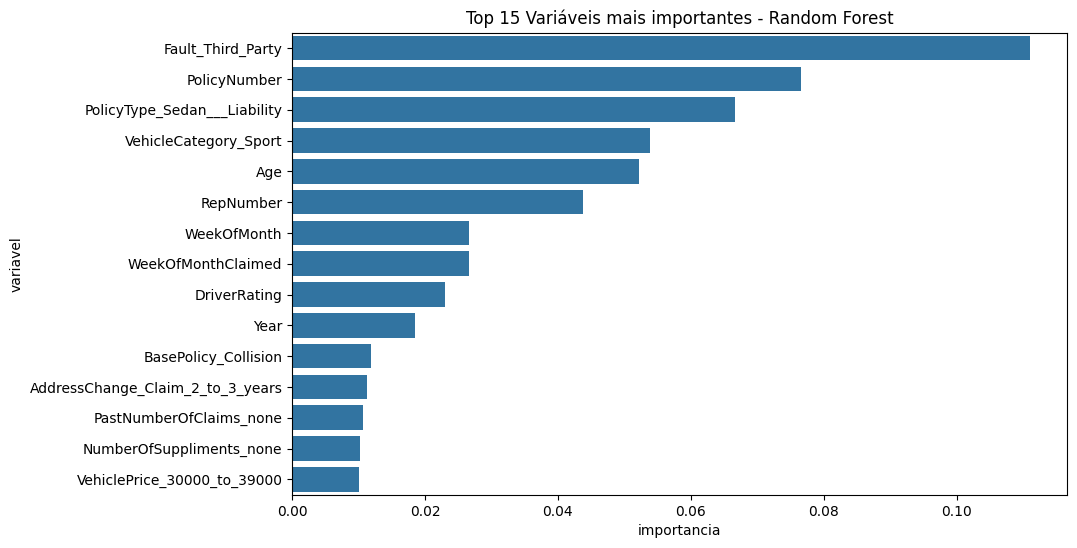

,variavel,importancia
50,Fault_Third_Party,0.111098
3,PolicyNumber,0.076560
52,PolicyType_Sedan___Liability,0.066615
55,VehicleCategory_Sport,0.053929
2,Age,0.052246
4,RepNumber,0.043763
0,WeekOfMonth,0.026621
1,WeekOfMonthClaimed,0.026547
6,DriverRating,0.023058
7,Year,0.018460


In [48]:
importances = pd.DataFrame({
'variavel': X.columns,
'importancia': rf.feature_importances_
}).sort_values(by='importancia', ascending=False)


plt.figure(figsize=(10,6))
sns.barplot(data=importances.head(15), x='importancia', y='variavel')
plt.title('Top 15 Variáveis mais importantes - Random Forest')
plt.show()


importances.head(20)

**Conclusão:**

As variáveis mais influentes no modelo incluem Fault_Third_Party, PolicyNumber e características do tipo de apólice e categoria do veículo, indicando que elementos relacionados à responsabilização, identificação da apólice e perfil do veículo tiveram maior impacto na distinção entre fraude e não fraude. Variáveis operacionais e comportamentais, como Age, RepNumber e DriverRating, também contribuíram de forma relevante, reforçando que o modelo se apoia em múltiplas dimensões para identificar padrões associados à fraude.

**Conclusao Geral:**

O modelo Random Forest apresentou boa capacidade discriminativa geral, refletida pelo AUC consistente, mas manteve baixa efetividade na identificação da classe fraudulenta, principalmente devido ao forte desbalanceamento. Apesar disso, identificou variáveis relevantes relacionadas à apólice, tipo de veículo e perfil do segurado, evidenciando potencial para capturar padrões importantes quando respaldado por técnicas adicionais de balanceamento ou ajustes futuros.

### Avaliação dos Modelos

In [43]:
print("AUC Logistic Regression (Baseline): 0.8065")
print("AUC Decision Tree:", round(0.8242, 4))
print("AUC Random Forest:", round(roc_auc, 4))


AUC Logistic Regression (Baseline): 0.8065
AUC Decision Tree: 0.8242
AUC Random Forest: 0.8705


**Conclusão - Comparação entre Modelos:**

A avaliação baseada no AUC-ROC indica diferenças claras de desempenho entre os modelos testados.

A **Regressão Logística** apresentou **AUC de 0.8065**, enquanto a **Árvore de Decisão** obteve **0.8242**, demonstrando leve ganho ao incorporar relações não lineares. O **Random Forest**, por sua vez, alcançou o **melhor resultado**, com **AUC de 0.8705**, evidenciando maior capacidade discriminativa ao combinar múltiplas árvores e reduzir a variabilidade das previsões.

Esses resultados consolidam o **Random Forest como o modelo mais eficaz entre os avaliados** para distinguir casos de fraude e não fraude no conjunto de dados.

### Thresholds para testar

Obs: O threshold é o ponto de corte utilizado para converter as probabilidades previstas pelo modelo em classes (fraude ou não fraude). Ajustar o threshold permite controlar o trade-off entre recall e precision, aumentando a sensibilidade do modelo a fraudes, mesmo que isso gere mais falsos positivos. Essa prática é especialmente relevante em cenários desbalanceados, como detecção de fraude, em que a prioridade é reduzir ao máximo falsos negativos.

In [47]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd

# Probabilidades preditas (classe positiva)
y_proba = rf.predict_proba(X_test)[:, 1]

# Thresholds para testar
thresholds = [0.5, 0.4, 0.3, 0.2, 0.1, 0.05]

resultados = []

for t in thresholds:
    y_pred_adj = (y_proba >= t).astype(int)
    
    precision = precision_score(y_test, y_pred_adj, zero_division=0)
    recall = recall_score(y_test, y_pred_adj, zero_division=0)
    f1 = f1_score(y_test, y_pred_adj, zero_division=0)
    cm = confusion_matrix(y_test, y_pred_adj)
    
    resultados.append([t, precision, recall, f1, cm[1,1], cm[1,0]])

# Criar dataframe para visualizar
df_thresholds = pd.DataFrame(
    resultados,
    columns=["Threshold", "Precision", "Recall", "F1", "TP", "FN"]
)

# Encontrar o melhor threshold com base no maior F1-score
best_row = df_thresholds.loc[df_thresholds["F1"].idxmax()]

print("=== Melhor Threshold Encontrado ===")
print(best_row)
print("\nTabela completa de Thresholds:")
df_thresholds



=== Melhor Threshold Encontrado ===
Threshold      0.100000
Precision      0.205910
Recall         0.805054
F1             0.327941
TP           223.000000
FN            54.000000
Name: 4, dtype: float64

Tabela completa de Thresholds:


,Threshold,Precision,Recall,F1,TP,FN
0,0.50,0.500000,0.007220,0.014235,2,275
1,0.40,0.636364,0.025271,0.048611,7,270
2,0.30,0.617647,0.075812,0.135048,21,256
3,0.20,0.333333,0.227437,0.270386,63,214
4,0.10,0.205910,0.805054,0.327941,223,54
5,0.05,0.132963,0.949458,0.233259,263,14


In [46]:
# Aplicando threshold selecionado (0.10)
optimal_threshold = 0.10
y_pred_thresh = (y_proba >= optimal_threshold).astype(int)

print("Classification Report com Threshold Ajustado:")
print(classification_report(y_test, y_pred_thresh))



Classification Report com Threshold Ajustado:
              precision    recall  f1-score   support

           0       0.98      0.80      0.88      4349
           1       0.21      0.81      0.33       277

    accuracy                           0.80      4626
   macro avg       0.60      0.80      0.61      4626
weighted avg       0.94      0.80      0.85      4626



**Interpretação das Métricas do Modelo (Threshold Ajustado)**

**Recall da Classe Fraudulenta (1) = 81%**
- **O que significa:** Se existirem 100 fraudes reais, o modelo consegue detectar 81.  
- **Tradução prática:** Poucas fraudes estão escapando — apenas 19 a cada 100 passam sem serem identificadas.  
> ✅ Esta é a métrica mais importante em detecção de fraude.

---

**Precision da Classe Fraudulenta (1) = 21%**
- **O que significa:** De cada 100 alertas que o modelo marca como fraude, apenas 21 realmente são fraude.  
- **Tradução prática:** O modelo gera muitos falsos positivos (79%), mas captura a maioria das fraudes, o que é aceitável quando o objetivo é **minimizar fraudes não detectadas**.

---

**F1-Score da Classe Fraudulenta (1) = 0.33**
- **O que significa:** Equilíbrio entre pegar fraudes (Recall) e evitar alarmes falsos (Precision).  
- **Tradução prática:** O modelo prioriza Recall, captura muitas fraudes, mas perde precisão — o F1 reflete esse trade-off.

---

**Acurácia Global = 80%**
- **O que significa:** 80% de todas as previsões estão corretas.  
- **Tradução prática:** Métrica enganosa em dados desbalanceados, pois acerta muitas “não fraudes”, mas não representa bem a performance sobre fraudes.

---

**Macro Average (F1 = 0.61)**
- **O que significa:** Média simples das métricas das duas classes (fraude e não fraude).  
- **Tradução prática:** Mostra um panorama balanceado da performance global, sem considerar o desbalanceamento.

---

**Weighted Average (F1 = 0.85)**
- **O que significa:** Média ponderada das métricas, dando mais peso à classe majoritária (não fraude).  
- **Tradução prática:** Parece bom por causa da classe majoritária, mas **não mostra a verdadeira performance sobre fraudes**, cuja precisão continua baixa.

---

**Resumo Final**
- O modelo **captura 81% das fraudes** (Recall alto).  
- **Gera muitos falsos positivos** (Precision baixo), mas isso é aceitável para minimizar fraudes não detectadas.  
- **Acurácia não é confiável** em cenários desbalanceados.  
- O modelo **prioriza sensibilidade (recall)** em vez de precisão, adequado para detecção de fraude.

**Conclusão do Threshold Ajustado:** 

A aplicação do threshold otimizado resultou em um aumento expressivo na capacidade de detecção de fraudes, elevando o recall da classe positiva para 0.81, ainda que à custa de uma redução significativa na precisão (0.21).

Esse ajuste produziu um modelo mais sensível aos casos de fraude, reduzindo substancialmente falsos negativos e oferecendo um desempenho mais adequado para cenários onde a identificação do evento positivo é prioritária. 

A acurácia geral reduziu para 0.80, mas o ganho em recall justifica o trade-off para o contexto de negócio.

# Fim